# **Analisis Sentimen Review Aplikasi "Mobile Legends" di Play Store**

# **Import Library**

In [3]:
!pip install swifter
!pip install Sastrawi
!pip install wordcloud

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 12.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for swifter: filename=swifter-1.4.0-py3-none-any.whl size=16505 sha256=0057e05fd153fe462b757ea2f19eb9776010bd3dd5897164ade70ef6bd0d960d
  Stored in directory: /root/.cache/pip/wheels/d9/31/ff/ff51141a088571a9f672449e5aad5ea8bb35ca5d95ba135f30
Successfully built swifter
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 209.7/209.7 kB 4.3 MB/s eta 0:00:00


In [4]:
import pandas as pd
import swifter
from tqdm.notebook import tqdm
pd.options.mode.chained_assignment = None
import numpy as np
seed = 0
np.random.seed(seed)
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score

import datetime as dt
import re
import string
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords

from Sastrawi.Stemmer.StemmerFactory import StemmerFactory
from Sastrawi.StopWordRemover.StopWordRemoverFactory import StopWordRemoverFactory

from wordcloud import WordCloud

import nltk
nltk.download('punkt')
nltk.download('punkt_tab')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [5]:
# Load dataset ulasan dari CSV
df = pd.read_csv("ulasan_aplikasi.csv")

print("DataFrame berhasil dibuat")
print("Jumlah data:", len(df))
df.head()

DataFrame berhasil dibuat
Jumlah data: 12000


,content,score
0,"Fix bug lag, saya dah 2 kali kena bug ngelag, ...",1
1,"bukannya makin bagus, malah makin parah lag-ny...",1
2,"semenjak update di akhir bulan September, ada ...",3
3,lagi main tiba tiba jaringan terputus sementar...,1
4,semenjak update malah suka ngelag pas di lobby...,1


In [6]:
# Menampilkan informasi dari DataFrame df
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12000 entries, 0 to 11999
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   content  12000 non-null  object
 1   score    12000 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 187.6+ KB


In [7]:
# Cek jumlah nilai NaN per kolom
df.isna().sum()

,0
content,0
score,0


In [8]:
# Menghapus baris yang memiliki nilai yang hilang (NaN)
clean_df = df

In [10]:
# Menampilkan informasi DataFrame clean_df setelah membersihkan nilai yang hilang (NaN)
clean_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12000 entries, 0 to 11999
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   content  12000 non-null  object
 1   score    12000 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 187.6+ KB


In [11]:
# Menghapus baris duplikat dari DataFrame clean_df
clean_df = clean_df.drop_duplicates()

# Menghitung jumlah baris dan kolom dalam DataFrame clean_df setelah menghapus duplikat
jumlah_ulasan_setelah_hapus_duplikat, jumlah_kolom_setelah_hapus_duplikat = clean_df.shape

In [12]:
clean_df.head()

,content,score
0,"Fix bug lag, saya dah 2 kali kena bug ngelag, ...",1
1,"bukannya makin bagus, malah makin parah lag-ny...",1
2,"semenjak update di akhir bulan September, ada ...",3
3,lagi main tiba tiba jaringan terputus sementar...,1
4,semenjak update malah suka ngelag pas di lobby...,1


# **Preprocessing**

In [ ]:
# Melakukan Cleaning Text
def cleaningText(text):
    text = re.sub(r'#[A-Za-z0-9_]+', '', str(text))
    text = re.sub(r'https?:\/\/\S+', '', text)
    text = re.sub(r'\n', ' ', text)
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    text = re.sub(r'\s+', ' ', text).strip()
    return text

# Melakukan Case Folding
def casefoldingText(text):
    return text.lower()

# Menghapus Slangword
slangwords_dict = {
    "gk": "tidak", "ga": "tidak", "ngga": "tidak", "nggak": "tidak", "engga": "tidak", "enggak": "tidak",
    "kaga": "tidak", "kgk": "tidak", "kagak": "tidak",
    "iya": "ya", "y": "ya", "yap": "ya", "yaudah": "ya sudah", "yaping": "ya", "yah": "ya",
    "tp": "tapi", "tpi": "tapi", "trus": "terus", "trs": "terus", "tq": "terima kasih",
    "mksh": "terima kasih", "makasih": "terima kasih", "mksih": "terima kasih", "thx": "terima kasih",
    "pls": "tolong", "plis": "tolong", "plss": "tolong",
    "udh": "sudah", "uda": "sudah", "sdh": "sudah", "udah": "sudah",
    "blm": "belum", "blom": "belum", "blum": "belum",
    "bgt": "banget", "bngt": "banget", "bangt": "banget",
    "aja": "saja", "aj": "saja", "doang": "saja", "tok": "saja",
    "dpt": "dapat", "dapet": "dapat", "dpet": "dapat",
    "jg": "juga", "jga": "juga",
    "sm": "sama", "ama": "sama",
    "dr": "dari", "dri": "dari",
    "krn": "karena", "karna": "karena",
    "kl": "kalau", "klo": "kalau", "kalo": "kalau",
    "bs": "bisa", "bsa": "bisa",
    "gmn": "bagaimana", "gmna": "bagaimana",
    "gw": "saya", "gua": "saya", "gue": "saya",
    "lo": "kamu", "lu": "kamu",
    "mantul": "mantap", "mantep": "mantap", "mantapp": "mantap",
    "anjir": "astaga", "anjay": "hebat",
    "wkwk": "haha", "wkwwk": "haha", "wkwwkwk": "haha",
    "pls": "tolong", "plis": "tolong", "plss": "tolong",
    "lemot": "lambat", "ngelag": "lag", "ngehang": "hang",
    "btw": "ngomong-ngomong", "omg": "ya ampun",
    "yg": "yang", "bbrp": "beberapa", "bt": "bete",
    "cmn": "cuma", "jd": "jadi", "jdnya": "jadinya",
    "mo": "mau", "mw": "mau", "ampe": "sampai", "smpe": "sampai",
    "pdhl": "padahal", "tpn": "tapi", "trnyata": "ternyata", "kluar": "keluar"
}

def normalize_slang(text, slang_dict):
    words = text.split()
    normalized_words = [slang_dict.get(w, w) for w in words]
    return " ".join(normalized_words)

# Menghapus Stopword
stop_factory = StopWordRemoverFactory()
stopword_list = set(stop_factory.get_stop_words() + stopwords.words('indonesian') +
                    ['ya', 'nya', 'sih', 'kok', 'nih', 'dong', 'deh'])

# Melakukan Stemming
factory = StemmerFactory()
stemmer = factory.create_stemmer()

def full_preprocess(text):
    if not isinstance(text, str):
        return ""
    # Cleaning
    text = cleaningText(text)
    # Case folding
    text = text.lower()
    # Normalisasi slang
    text = normalize_slang(text, slangwords_dict)
    # Tokenizing
    words = word_tokenize(text)
    # Stopword removal
    words = [w for w in words if w not in stopword_list]
    # Stemming
    words = [stemmer.stem(w) for w in words]
    # Gabungkan kembali jadi kalimat
    return ' '.join(words)

tqdm.pandas()

clean_df['text_final'] = clean_df['content'].swifter.apply(full_preprocess)
clean_df[['content', 'text_final']]

Pandas Apply: 100%|██████████| 12000/12000 [16:06<00:00, 12.42it/s] 


,content,text_final
0,"Fix bug lag, saya dah 2 kali kena bug ngelag, ...",fix bug lag dah kali kena bug lag jaring rumah...
1,"bukannya makin bagus, malah makin parah lag-ny...",bagus parah lagnya tau setting mode speed ting...
2,"semenjak update di akhir bulan September, ada ...",semenjak update september bug notifikasi kill ...
3,lagi main tiba tiba jaringan terputus sementar...,main jaring putus data hidup jaring bagus maba...
4,semenjak update malah suka ngelag pas di lobby...,semenjak update suka lag pas lobby login liat ...
...,...,...
11995,kenapa saya pas login ml (terjadi kesalahan (-...,pas login ml salah sila coba baik cepat
11996,"gamenya keren banget, event dan collab itu yan...",gamenya keren banget event collab seru suka ml...
11997,Saya tidak menemukan ikon edit nama squad di a...,temu ikon edit nama squad akun customer servic...
11998,"Lebih ke jaringan sih, tambah ngebug nya ga bi...",jaring ngebug masuk gara ganti hp


In [ ]:
# Simpan dataframe ke CSV
clean_df.to_csv("cleaned_reviews.csv", index=False, encoding="utf-8")

print("File berhasil disimpan sebagai cleaned_reviews.csv")

File berhasil disimpan sebagai cleaned_reviews.csv


# **Pelabelan**

In [13]:
# Load dataset hasil preprocessing
df_preprocessed = pd.read_csv("cleaned_reviews.csv")

print("Jumlah data:", len(df_preprocessed))
df_preprocessed.head()



Jumlah data: 12000


,content,score,text_final
0,"Fix bug lag, saya dah 2 kali kena bug ngelag, ...",1,fix bug lag dah kali kena bug lag jaring rumah...
1,"bukannya makin bagus, malah makin parah lag-ny...",1,bagus parah lagnya tau setting mode speed ting...
2,"semenjak update di akhir bulan September, ada ...",3,semenjak update september bug notifikasi kill ...
3,lagi main tiba tiba jaringan terputus sementar...,1,main jaring putus data hidup jaring bagus maba...
4,semenjak update malah suka ngelag pas di lobby...,1,semenjak update suka lag pas lobby login liat ...


In [14]:
import csv
import requests
from io import StringIO
import pandas as pd


lexicon_positive = {}
url_pos = 'https://raw.githubusercontent.com/angelmetanosaa/dataset/main/lexicon_positive.csv'
res = requests.get(url_pos)
if res.status_code == 200:
    reader = csv.reader(StringIO(res.text), delimiter=',')
    for row in reader:
        try:
            lexicon_positive[row[0].strip()] = int(row[1])
        except:
            continue
else:
    print("Gagal memuat lexicon positif")


lexicon_negative = {}
url_neg = 'https://raw.githubusercontent.com/angelmetanosaa/dataset/main/lexicon_negative.csv'
res = requests.get(url_neg)
if res.status_code == 200:
    reader = csv.reader(StringIO(res.text), delimiter=',')
    for row in reader:
        try:
            lexicon_negative[row[0].strip()] = int(row[1])
        except:
            continue
else:
    print("Gagal memuat lexicon negatif")


def sentiment_analysis_lexicon(text, th=1):
    """
    Analisis sentimen berbasis lexicon.
    Keluaran:
        - Label sentimen: 'positif', 'netral', 'negatif'
        - Skor numerik total (opsional)
    Parameter:
        th (threshold): ambang untuk menentukan zona netral
    """
    if not isinstance(text, str) or text.strip() == "":
        return 0, "netral"   # skor 0 = netral

    words = text.split()
    score = 0

    # Hitung total skor
    for word in words:
        if word in lexicon_positive:
            score += lexicon_positive[word]
        elif word in lexicon_negative:
            score += lexicon_negative[word]

    # Klasifikasi 3 kelas berdasarkan threshold
    if score >= th:
        label = "positif"
    elif score <= -th:
        label = "negatif"
    else:
        label = "netral"

    return score, label


df_preprocessed['text_final'] = df_preprocessed['text_final'].astype(str).fillna("")

hasil = df_preprocessed['text_final'].apply(lambda x: sentiment_analysis_lexicon(x, th=2))
hasil = list(zip(*hasil))

df_preprocessed['lexicon_score'] = hasil[0]
df_preprocessed['lexicon_label'] = hasil[1]



print("\nDistribusi Label Lexicon:")
print(df_preprocessed['lexicon_label'].value_counts())


Distribusi Label Lexicon:
lexicon_label
positif    8024
negatif    2813
netral     1163
Name: count, dtype: int64


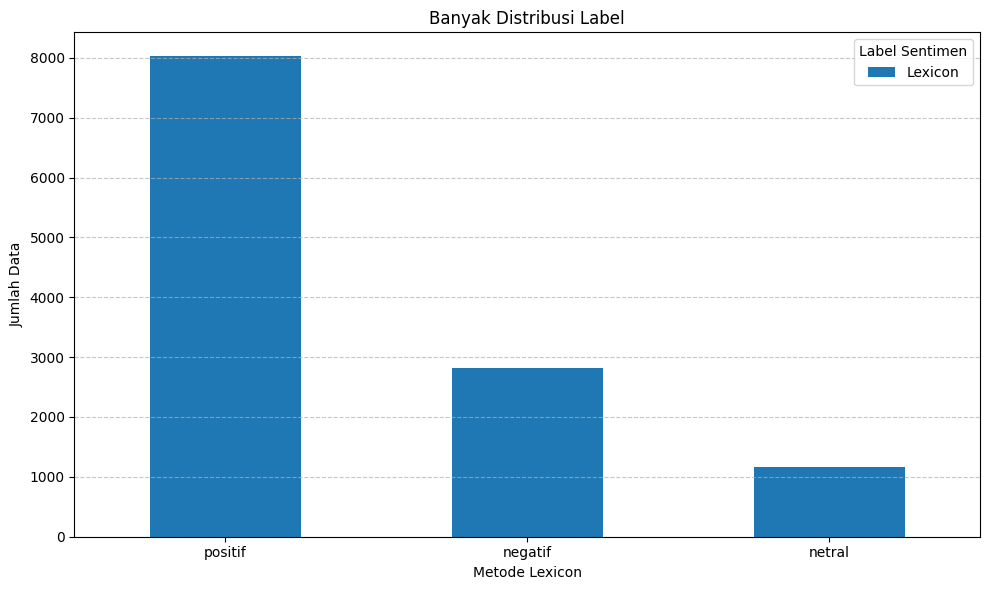

               Lexicon
lexicon_label         
positif           8024
negatif           2813
netral            1163


In [16]:
banyak_distribusi = pd.DataFrame({
    "Lexicon": df_preprocessed['lexicon_label'].value_counts()
}).fillna(0).astype(int)

# Plot
banyak_distribusi_T = banyak_distribusi.T
ax = banyak_distribusi.plot(
    kind='bar',
    figsize=(10,6),
    title='Banyak Distribusi Label',
    rot=0
)

plt.xlabel("Metode Lexicon")
plt.ylabel("Jumlah Data")
plt.legend(title="Label Sentimen")
plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()

print(banyak_distribusi)

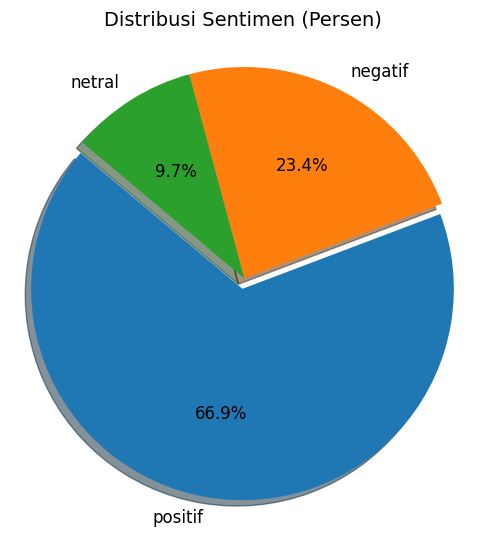

,content,score,text_final,lexicon_score,lexicon_label
0,"Fix bug lag, saya dah 2 kali kena bug ngelag, ...",1,fix bug lag dah kali kena bug lag jaring rumah...,9,positif
1,"bukannya makin bagus, malah makin parah lag-ny...",1,bagus parah lagnya tau setting mode speed ting...,8,positif
2,"semenjak update di akhir bulan September, ada ...",3,semenjak update september bug notifikasi kill ...,9,positif
3,lagi main tiba tiba jaringan terputus sementar...,1,main jaring putus data hidup jaring bagus maba...,29,positif
4,semenjak update malah suka ngelag pas di lobby...,1,semenjak update suka lag pas lobby login liat ...,4,positif


In [17]:
persen = df_preprocessed['lexicon_label'].value_counts()
labels = persen.index
sizes = persen.values

explode = [0.05 if label == persen.index[0] else 0 for label in persen.index]
fig, ax = plt.subplots(figsize=(6, 6))
ax.pie(
    sizes,
    labels=labels,
    autopct='%1.1f%%',
    startangle=140,
    explode=explode,
    shadow=True,
    textprops={'fontsize': 12})

ax.set_title('Distribusi Sentimen (Persen)', fontsize=14, pad=20)
ax.axis('equal')

plt.show()


df_preprocessed.head()

In [18]:
# Drop kolom yang tidak diperlukan
df_preprocessed = df_preprocessed.drop(columns=['content', 'score'])

df_preprocessed.head()

,text_final,lexicon_score,lexicon_label
0,fix bug lag dah kali kena bug lag jaring rumah...,9,positif
1,bagus parah lagnya tau setting mode speed ting...,8,positif
2,semenjak update september bug notifikasi kill ...,9,positif
3,main jaring putus data hidup jaring bagus maba...,29,positif
4,semenjak update suka lag pas lobby login liat ...,4,positif


In [19]:
from sklearn.preprocessing import LabelEncoder

# Inisialisasi LabelEncoder
le = LabelEncoder()

df_preprocessed["lexicon_label"] = le.fit_transform(df_preprocessed["lexicon_label"])

print("Encoding selesai")
print(dict(zip(le.classes_, le.transform(le.classes_))))

print(df_preprocessed.head())

Encoding selesai
{'negatif': np.int64(0), 'netral': np.int64(1), 'positif': np.int64(2)}
                                          text_final  lexicon_score  \
0  fix bug lag dah kali kena bug lag jaring rumah...              9   
1  bagus parah lagnya tau setting mode speed ting...              8   
2  semenjak update september bug notifikasi kill ...              9   
3  main jaring putus data hidup jaring bagus maba...             29   
4  semenjak update suka lag pas lobby login liat ...              4   

   lexicon_label  
0              2  
1              2  
2              2  
3              2  
4              2  


# **Ekstraksi Fitur**

In [20]:
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier
from scipy.sparse import hstack
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, GRU, Dense, Dropout
import seaborn as sns
import matplotlib.pyplot as plt

## SKEMA 1 : Support Vector Machine + TF-IDF + SPLIT DATA (80:20)

Fitur lexicon_score ditambahkan ke TF-IDF
Fitting 3 folds for each of 6 candidates, totalling 18 fits

HASIL MODEL 1: SVM + TF-IDF + Split 80:20
Best C: 0.5
Accuracy: 98.67%

Classification Report:
              precision    recall  f1-score   support

           0      0.979     1.000     0.989       562
           1      1.000     0.863     0.926       233
           2      0.988     1.000     0.994      1605

    accuracy                          0.987      2400
   macro avg      0.989     0.954     0.970      2400
weighted avg      0.987     0.987     0.986      2400



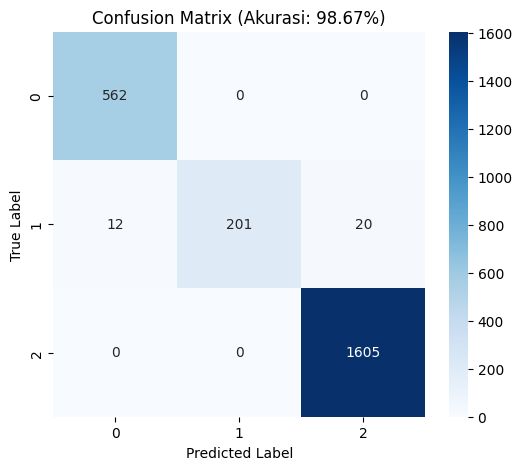

In [23]:
text_col = "text_final"
label_col = "lexicon_label"

X = df_preprocessed[text_col].astype(str)
y = df_preprocessed[label_col]

# Split data
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    stratify=y,
    random_state=42
)


tfidf = TfidfVectorizer(
    max_features=10000,
    ngram_range=(1, 3),
    sublinear_tf=True,
    min_df=3,
    max_df=0.9
)

X_train_tfidf = tfidf.fit_transform(X_train)
X_test_tfidf  = tfidf.transform(X_test)


if "lexicon_score" in df_preprocessed.columns:
    lex_train = np.array(df_preprocessed.loc[X_train.index, "lexicon_score"]).reshape(-1, 1)
    lex_test  = np.array(df_preprocessed.loc[X_test.index, "lexicon_score"]).reshape(-1, 1)
    X_train_final = hstack([X_train_tfidf, lex_train])
    X_test_final  = hstack([X_test_tfidf, lex_test])
    print("Fitur lexicon_score ditambahkan ke TF-IDF")
else:
    X_train_final, X_test_final = X_train_tfidf, X_test_tfidf
    print("Kolom 'lexicon_score' tidak ditemukan — hanya gunakan TF-IDF")


param_grid = {"C": [0.1, 0.5, 1, 2, 5, 10]}
grid = GridSearchCV(
    LinearSVC(random_state=42),
    param_grid,
    scoring="accuracy",
    cv=3,
    n_jobs=-1,
    verbose=1
)

grid.fit(X_train_final, y_train)
best_svc = grid.best_estimator_

best_svc.fit(X_train_final, y_train)


y_pred = best_svc.predict(X_test_final)
acc = accuracy_score(y_test, y_pred)

print("\nHASIL MODEL 1: SVM + TF-IDF + Split 80:20")
print(f"Best C: {grid.best_params_['C']}")
print(f"Accuracy: {acc*100:.2f}%")
print("\nClassification Report:")
print(classification_report(y_test, y_pred, digits=3))


cm = confusion_matrix(y_test, y_pred, labels=best_svc.classes_)
plt.figure(figsize=(6,5))
sns.heatmap(
    cm, annot=True, fmt="d", cmap="Blues",
    xticklabels=best_svc.classes_, yticklabels=best_svc.classes_
)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title(f"Confusion Matrix (Akurasi: {acc*100:.2f}%)")
plt.show()

## SKEMA 2 : RANDOM FOREST + TF-IDF + SPLIT DATA (80:20)

Jumlah fitur: 8000
Fitur lexicon_score ditambahkan ke TF-IDF.
Fitting 3 folds for each of 162 candidates, totalling 486 fits

Best Parameters: {'bootstrap': False, 'max_depth': 40, 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 400}
HASIL MODEL 2: Random Forest + TF-IDF + Split 80:20
Best Params: {'bootstrap': False, 'max_depth': 40, 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 400}
Accuracy: 86.71%

Classification Report:
              precision    recall  f1-score   support

           0      0.888     0.845     0.866       562
           1      1.000     0.009     0.017       233
           2      0.861     0.999     0.925      1605

    accuracy                          0.867      2400
   macro avg      0.916     0.618     0.603      2400
weighted avg      0.881     0.867     0.823      2400



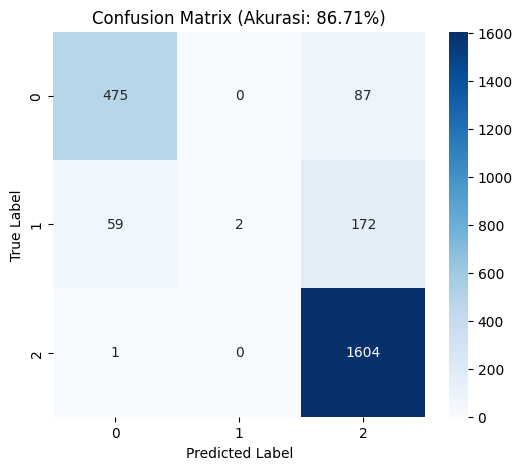

In [25]:
text_col = "text_final"
label_col = "lexicon_label"
lexicon_col = "lexicon_score"

X = df_preprocessed[text_col].astype(str)
y = df_preprocessed[label_col]

# Split Data
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    stratify=y,
    random_state=42
)


tfidf = TfidfVectorizer(
    max_features=8000,
    ngram_range=(1, 2),
    sublinear_tf=True,
    min_df=3,
    max_df=0.9
)

X_train_tfidf = tfidf.fit_transform(X_train)
X_test_tfidf  = tfidf.transform(X_test)

print(f"Jumlah fitur: {X_train_tfidf.shape[1]}")


if lexicon_col in df_preprocessed.columns:
    lex_train = np.array(df_preprocessed.loc[X_train.index, lexicon_col]).reshape(-1, 1)
    lex_test  = np.array(df_preprocessed.loc[X_test.index, lexicon_col]).reshape(-1, 1)

    X_train_final = hstack([X_train_tfidf, lex_train])
    X_test_final  = hstack([X_test_tfidf, lex_test])
    print("Fitur lexicon_score ditambahkan ke TF-IDF.")
else:
    X_train_final, X_test_final = X_train_tfidf, X_test_tfidf
    print("Kolom 'lexicon_score' tidak ditemukan — hanya gunakan TF-IDF.")


rf = RandomForestClassifier(random_state=42, n_jobs=-1)

param_grid = {
    "n_estimators": [200, 400, 600],
    "max_depth": [20, 30, 40],
    "min_samples_split": [2, 5, 10],
    "min_samples_leaf": [1, 2, 4],
    "bootstrap": [True, False]
}

grid_rf = GridSearchCV(
    estimator=rf,
    param_grid=param_grid,
    scoring="accuracy",
    cv=3,
    n_jobs=-1,
    verbose=2
)

grid_rf.fit(X_train_final, y_train)
best_rf = grid_rf.best_estimator_

print(f"\nBest Parameters: {grid_rf.best_params_}")


y_pred = best_rf.predict(X_test_final)
acc = accuracy_score(y_test, y_pred)

print("HASIL MODEL 2: Random Forest + TF-IDF + Split 80:20")
print(f"Best Params: {grid_rf.best_params_}")
print(f"Accuracy: {acc*100:.2f}%")
print("\nClassification Report:")
print(classification_report(y_test, y_pred, digits=3))


cm = confusion_matrix(y_test, y_pred, labels=best_rf.classes_)
plt.figure(figsize=(6,5))
sns.heatmap(
    cm, annot=True, fmt="d", cmap="Blues",
    xticklabels=best_rf.classes_, yticklabels=best_rf.classes_
)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title(f"Confusion Matrix (Akurasi: {acc*100:.2f}%)")
plt.show()

## SKEMA 3 : GRU + Word2Vec + SPLIT DATA (70:30)

Jumlah kata unik: 13523
Word2Vec dilatih. Dimensi embedding: 100


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 100)]                0         []                            
                                                                                                  
 embedding (Embedding)       (None, 100, 100)             1352300   ['input_1[0][0]']             
                                                                                                  
 gru (GRU)                   (None, 256)                  274944    ['embedding[0][0]']           
                                                                                                  
 input_2 (InputLayer)        [(None, 1)]                  0         []                            
                                                                                              

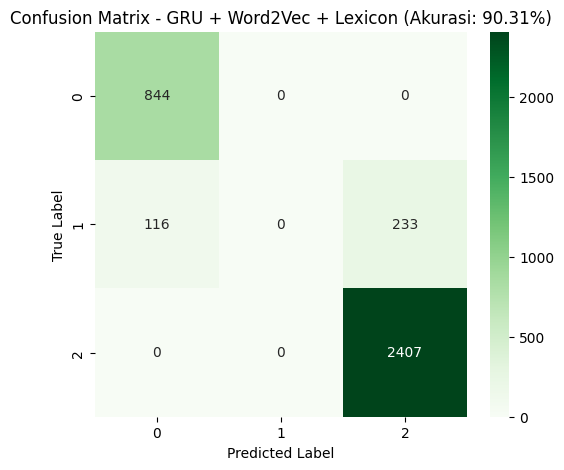

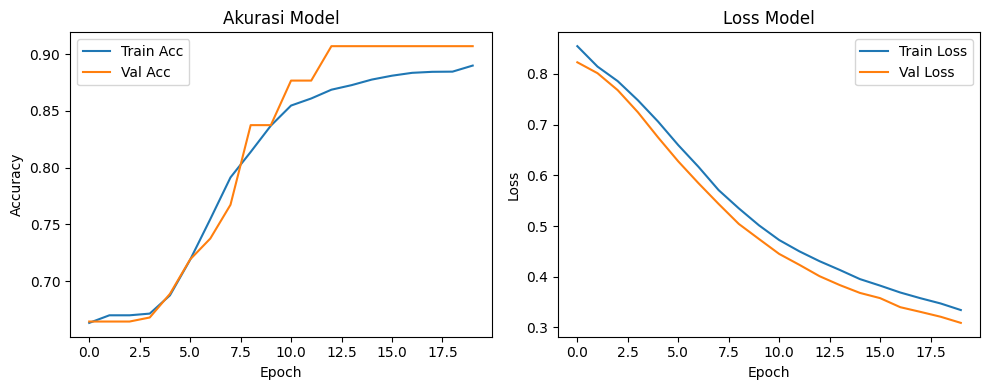

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Embedding, GRU, Dense, Dropout, Concatenate
from tensorflow.keras.optimizers import Adam
from gensim.models import Word2Vec

text_col = "text_final"
label_col = "lexicon_label"
lexicon_col = "lexicon_score"

X_text = df_preprocessed[text_col].astype(str)
X_lexicon = df_preprocessed[lexicon_col].astype(float).values.reshape(-1, 1)
y = df_preprocessed[label_col]

encoder = LabelEncoder()
y_encoded = encoder.fit_transform(y)

scaler = MinMaxScaler()
X_lexicon_scaled = scaler.fit_transform(X_lexicon)

X_text_train, X_text_test, X_lex_train, X_lex_test, y_train, y_test = train_test_split(
    X_text, X_lexicon_scaled, y_encoded,
    test_size=0.3,
    stratify=y_encoded,
    random_state=42
)

max_words = 20000
max_len = 100

tokenizer = Tokenizer(num_words=max_words, oov_token="<OOV>")
tokenizer.fit_on_texts(X_text_train)

X_train_seq = tokenizer.texts_to_sequences(X_text_train)
X_test_seq  = tokenizer.texts_to_sequences(X_text_test)

X_train_pad = pad_sequences(X_train_seq, maxlen=max_len, padding='post', truncating='post')
X_test_pad  = pad_sequences(X_test_seq, maxlen=max_len, padding='post', truncating='post')

vocab_size = min(max_words, len(tokenizer.word_index) + 1)
print(f"Jumlah kata unik: {vocab_size}")

sentences = [text.split() for text in X_text_train]

w2v_model = Word2Vec(
    sentences=sentences,
    vector_size=100,
    window=5,
    min_count=3,
    workers=4,
    sg=1
)

embedding_dim = w2v_model.vector_size
print(f"Word2Vec dilatih. Dimensi embedding: {embedding_dim}")

embedding_matrix = np.zeros((vocab_size, embedding_dim))
for word, i in tokenizer.word_index.items():
    if i < vocab_size and word in w2v_model.wv:
        embedding_matrix[i] = w2v_model.wv[word]

text_input = Input(shape=(max_len,))
embedding_layer = Embedding(
    vocab_size, embedding_dim, weights=[embedding_matrix],
    input_length=max_len, trainable=False
)(text_input)

gru_out = GRU(256, dropout=0.2, recurrent_dropout=0.2)(embedding_layer)
dense_text = Dense(128, activation='relu')(gru_out)

lex_input = Input(shape=(1,))
dense_lex = Dense(32, activation='relu')(lex_input)

concat = Concatenate()([dense_text, dense_lex])
drop = Dropout(0.3)(concat)
output = Dense(len(np.unique(y_encoded)), activation='softmax')(drop)

model = Model(inputs=[text_input, lex_input], outputs=output)
model.compile(
    loss='sparse_categorical_crossentropy',
    optimizer=Adam(learning_rate=1e-3),
    metrics=['accuracy']
)

model.summary()

y_train = np.array(y_train).reshape(-1)
y_test  = np.array(y_test).reshape(-1)

history = model.fit(
    [X_train_pad, X_lex_train],
    y_train,
    validation_split=0.2,
    epochs=20,
    batch_size=64,
    verbose=1
)

y_pred_prob = model.predict([X_test_pad, X_lex_test])
y_pred = np.argmax(y_pred_prob, axis=1)

acc = accuracy_score(y_test, y_pred)

print("\n=== HASIL MODEL: GRU + Word2Vec + Lexicon ===")
print(f"Accuracy: {acc*100:.2f}%")
print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=[str(lbl) for lbl in encoder.classes_], digits=3))

cm = confusion_matrix(y_test, y_pred, labels=[0, 1, 2])
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Greens",
            xticklabels=[0, 1, 2], yticklabels=[0, 1, 2])
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title(f"Confusion Matrix - GRU + Word2Vec + Lexicon (Akurasi: {acc*100:.2f}%)")
plt.show()

plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.title('Akurasi Model')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1,2,2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Loss Model')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.tight_layout()
plt.show()

In [ ]:
import numpy as np

new_reviews = [
    "Game ini sangat seru dan bikin ketagihan!",
    "Aplikasi sering crash, bikin kecewa.",
    "Biasa saja, tidak terlalu bagus tapi lumayan.",
    "Game yang sangat menarik",
    "sangat menarik",
    "game jelek",
    "Saya sudah bermain game ini selama lebih dari dua tahun, awalnya sangat menyenangkan tetapi semakin ke sini sering ada bug dan update yang justru membuat performa semakin lambat.",
    "Sistem pembayarannya membingungkan, saya sudah coba berkali-kali tetap gagal. Tolong segera diperbaiki karena ini membuat saya kecewa.",
    "Mantap banget, grafiknya keren, kontrolnya mudah dipahami, dan banyak fitur baru yang bikin pengalaman bermain jadi menyenangkan!",
    "Sayangnya game ini sering sekali lag padahal saya pakai internet cepat. Kalau masalah server bisa diperbaiki pasti akan lebih bagus.",
    "Tidak sesuai ekspektasi, banyak iklan yang mengganggu dan membuat pengalaman bermain sangat buruk.",
    "Permainan ini bagus sekali untuk mengisi waktu luang, terutama kalau main bersama teman. Sangat recommended!",
    "Saya suka dengan konsep gamenya, tapi sayangnya banyak cheater yang bikin permainan jadi tidak adil. Mohon segera ditindak tegas.",
    "Aplikasi ini menurut saya biasa saja, tidak jelek tapi juga tidak luar biasa. Cocok untuk yang sekadar ingin coba-coba.",
    "Awalnya saya ragu untuk mendownload game ini, tetapi setelah dicoba ternyata sangat seru dan membuat saya ketagihan setiap hari."
]

new_seq = tokenizer.texts_to_sequences(new_reviews)
new_pad = pad_sequences(new_seq, maxlen=max_len, padding='post', truncating='post')

def sentiment_analysis_lexicon(text):
    if not isinstance(text, str) or text.strip() == "":
        return 0
    words = text.split()
    score = 0
    for word in words:
        if word in lexicon_positive:
            score += lexicon_positive[word]
        elif word in lexicon_negative:
            score += lexicon_negative[word]
    return score

new_lexicon_scores = np.array([sentiment_analysis_lexicon(r) for r in new_reviews]).reshape(-1, 1)
new_lexicon_scaled = scaler.transform(new_lexicon_scores)

#Menggunakan Model GRU (Skema 3)
pred_probs = model.predict([new_pad, new_lexicon_scaled])
pred_labels = np.argmax(pred_probs, axis=1)

mapping = {0: "NEGATIF", 1: "NETRAL", 2: "POSITIF"}

print("\n=== HASIL INFERENSI (PREDIKSI REVIEW BARU) ===\n")
for i, (review, label_idx, prob) in enumerate(zip(new_reviews, pred_labels, pred_probs), start=1):
    label = mapping[int(label_idx)]
    confidence = np.max(prob) * 100
    print(f"[{i}] Ulasan: {review}")
    print(f"Prediksi Sentimen: {label}  ({confidence:.2f}%)")
    print("=" * 100)

1/1 [==============================] - 0s 50ms/step

=== HASIL INFERENSI (PREDIKSI REVIEW BARU) ===

[1] Ulasan: Game ini sangat seru dan bikin ketagihan!
Prediksi Sentimen: POSITIF  (92.28%)
[2] Ulasan: Aplikasi sering crash, bikin kecewa.
Prediksi Sentimen: POSITIF  (71.82%)
[3] Ulasan: Biasa saja, tidak terlalu bagus tapi lumayan.
Prediksi Sentimen: NEGATIF  (74.90%)
[4] Ulasan: Game yang sangat menarik
Prediksi Sentimen: POSITIF  (64.64%)
[5] Ulasan: sangat menarik
Prediksi Sentimen: POSITIF  (89.90%)
[6] Ulasan: game jelek
Prediksi Sentimen: NEGATIF  (55.85%)
[7] Ulasan: Saya sudah bermain game ini selama lebih dari dua tahun, awalnya sangat menyenangkan tetapi semakin ke sini sering ada bug dan update yang justru membuat performa semakin lambat.
Prediksi Sentimen: POSITIF  (99.43%)
[8] Ulasan: Sistem pembayarannya membingungkan, saya sudah coba berkali-kali tetap gagal. Tolong segera diperbaiki karena ini membuat saya kecewa.
Prediksi Sentimen: POSITIF  (71.82%)
[9] Ulasan: Manta

In [26]:
!pip freeze > requirements.txt

In [27]:
!cat requirements.txt

absl-py==1.4.0
absolufy-imports==0.3.1
accelerate==1.10.1
aiofiles==24.1.0
aiohappyeyeballs==2.6.1
aiohttp==3.13.0
aiosignal==1.4.0
alabaster==1.0.0
albucore==0.0.24
albumentations==2.0.8
ale-py==0.11.2
alembic==1.16.5
altair==5.5.0
annotated-types==0.7.0
antlr4-python3-runtime==4.9.3
anyio==4.11.0
anywidget==0.9.18
argon2-cffi==25.1.0
argon2-cffi-bindings==25.1.0
array_record==0.8.1
arrow==1.3.0
arviz==0.22.0
astropy==7.1.0
astropy-iers-data==0.2025.10.6.0.35.25
astunparse==1.6.3
atpublic==5.1
attrs==25.4.0
audioread==3.0.1
Authlib==1.6.5
autograd==1.8.0
babel==2.17.0
backcall==0.2.0
beartype==0.22.2
beautifulsoup4==4.13.5
betterproto==2.0.0b6
bigframes==2.24.0
bigquery-magics==0.10.3
bleach==6.2.0
blinker==1.9.0
blis==1.3.0
blobfile==3.1.0
blosc2==3.10.0
bokeh==3.7.3
Bottleneck==1.4.2
bqplot==0.12.45
branca==0.8.2
Brotli==1.1.0
build==1.3.0
CacheControl==0.14.3
cachetools==5.5.2
catalogue==2.0.10
certifi==2025.10.5
cffi==2.0.0
chardet==5.2.0
charset-normalizer==3.4.3
chex==0.1.90
cla

In [28]:
from google.colab import files
files.download('requirements.txt')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>